# Cross-sectional analysis

- what was the situation in 2013 vs 2023? (air quality, fleet share, per country)

In [12]:
import os
# SET FIGURE PATH
# change figpath to figures/analysis_cross_section´
figpath = "../figures/analysis_cross_section"
os.makedirs(figpath, exist_ok=True)

In [13]:
import pandas as pd

# Load processed data
aq = pd.read_csv("../data/processed/AQ_annual_averages.csv")
vehicle = pd.read_csv("../data/processed/combined_vehicle_data.csv")

# Filter for 2013 and 2023
years = [2013, 2023]
aq_13_23 = aq[aq['Year'].isin(years)]
vehicle_13_23 = vehicle[vehicle['Year'].isin(years)]

# Merge on Country and Year
merged = aq_13_23.merge(vehicle_13_23, on=['Country', 'Year'], how='left')

# Show summary: mean and std for each pollutant and year, per country
summary = (
    merged.groupby(['Country', 'Pollutant', 'Year'])
    .agg(
        AQ_Mean=('AnnualAvg_fullweek_Daytime', 'mean'),
        AQ_Std=('AnnualAvg_fullweek_Daytime', 'std'),
        AF_Fleet=('AF_fleet', 'mean'),
        BEV_Fleet=('BEV_fleet', 'mean')
    )
    .reset_index()
)

print(summary)

# Optional: Pivot for easier comparison
pivot = summary.pivot(index=['Country', 'Pollutant'], columns='Year', values=['AQ_Mean', 'AF_Fleet', 'BEV_Fleet'])
pivot

   Country   Pollutant  Year    AQ_Mean  AQ_Std  AF_Fleet  BEV_Fleet
0       AT         CO2  2013  57.686461     NaN      0.13       0.04
1       AT         CO2  2023  67.359957     NaN      4.23       3.00
2       AT          NO  2013  19.883202     NaN      0.13       0.04
3       AT          NO  2023  13.783008     NaN      4.23       3.00
4       AT         NO2  2013  25.984084     NaN      0.13       0.04
5       AT         NO2  2023  16.259885     NaN      4.23       3.00
6       AT  NOX as NO2  2013   9.905672     NaN      0.13       0.04
7       AT  NOX as NO2  2023   7.852644     NaN      4.23       3.00
8       AT        PM10  2013   4.286946     NaN      0.13       0.04
9       AT        PM10  2023   2.078151     NaN      4.23       3.00
10      CH         CO2  2023  58.425153     NaN      5.62       3.33
11      CH         NO2  2023  20.767975     NaN      5.62       3.33
12      CH        PM10  2023   8.188244     NaN      5.62       3.33
13      CH       PM2.5  2023  34.9

AQ_Mean            AF_Fleet        BEV_Fleet       
Year                     2013       2023     2013   2023      2013   2023
Country Pollutant                                                        
AT      CO2         57.686461  67.359957     0.13   4.23      0.04   3.00
        NO          19.883202  13.783008     0.13   4.23      0.04   3.00
        NO2         25.984084  16.259885     0.13   4.23      0.04   3.00
        NOX as NO2   9.905672   7.852644     0.13   4.23      0.04   3.00
        PM10         4.286946   2.078151     0.13   4.23      0.04   3.00
CH      CO2               NaN  58.425153      NaN   5.62       NaN   3.33
        NO2               NaN  20.767975      NaN   5.62       NaN   3.33
        PM10              NaN   8.188244      NaN   5.62       NaN   3.33
        PM2.5             NaN  34.996214      NaN   5.62       NaN   3.33
DK      CO2               NaN  60.670749      NaN  11.31       NaN   7.00
        NO                NaN  21.055294      NaN  11.31       NaN   7.00
        NO2               NaN  15.732199      NaN  11.31       NaN   7.00
        NOX as NO2        NaN   6.631411      NaN  11.31       NaN   7.00
        PM10         3.429345  11.749182     0.06  11.31      0.06   7.00
        PM2.5             NaN  38.853788      NaN  11.31       NaN   7.00
NL      CO2         45.888203  57.793416     2.99   9.10      0.05   4.95
        NO          20.840983  15.691998     2.99   9.10      0.05   4.95
        NO2               NaN  19.359765      NaN   9.10       NaN   4.95
        NOX as NO2  10.719079   7.421154     2.99   9.10      0.05   4.95
        PM10              NaN   6.295661      NaN   9.10       NaN   4.95
        PM2.5             NaN  29.896216      NaN   9.10       NaN   4.95
NO      CO2         42.594027  50.773452     0.66  28.11      0.62  22.01
        NO          18.308956  12.780374     0.66  28.11      0.62  22.01
        NO2         34.452398  21.400352     0.66  28.11      0.62  22.01
        NOX as NO2   9.169427   5.825343     0.66  28.11      0.62  22.01
        PM10        14.931768   9.322129     0.66  28.11      0.62  22.01
        PM2.5       62.385491  37.334601     0.66  28.11      0.62  22.01
SE      CO2         42.463848  59.177150     0.89  12.06      0.02   5.86
        NO          17.590155  11.811886     0.89  12.06      0.02   5.86
        NO2         31.240048  17.822257     0.89  12.06      0.02   5.86
        NOX as NO2   6.164477   4.617759     0.89  12.06      0.02   5.86
        PM2.5       51.266317  35.021454     0.89  12.06      0.02   5.86

Figure already exists: ../figures/analysis_cross_section\CO2_first_vs_last_year_by_country.png


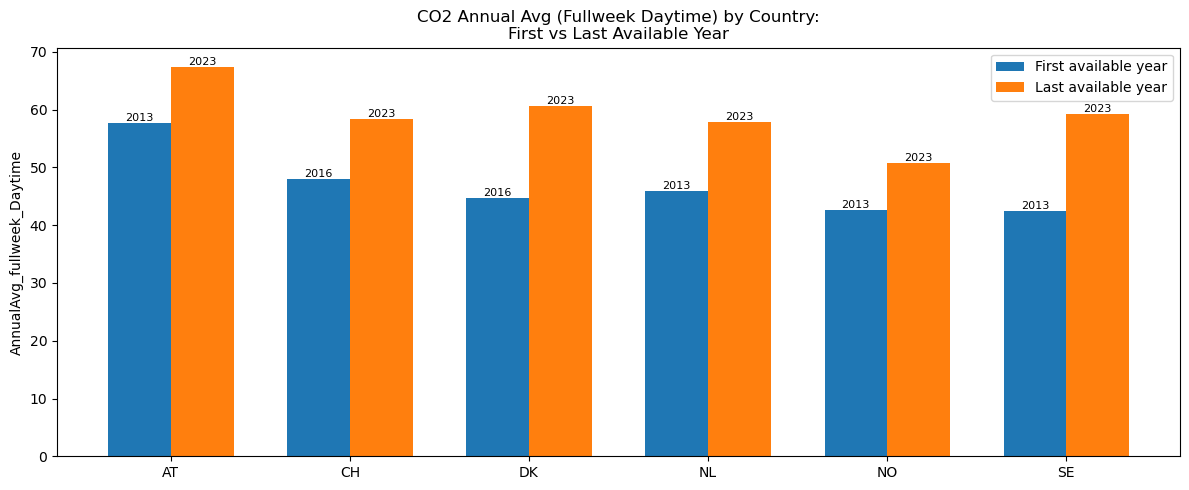

Figure already exists: ../figures/analysis_cross_section\NO2_first_vs_last_year_by_country.png


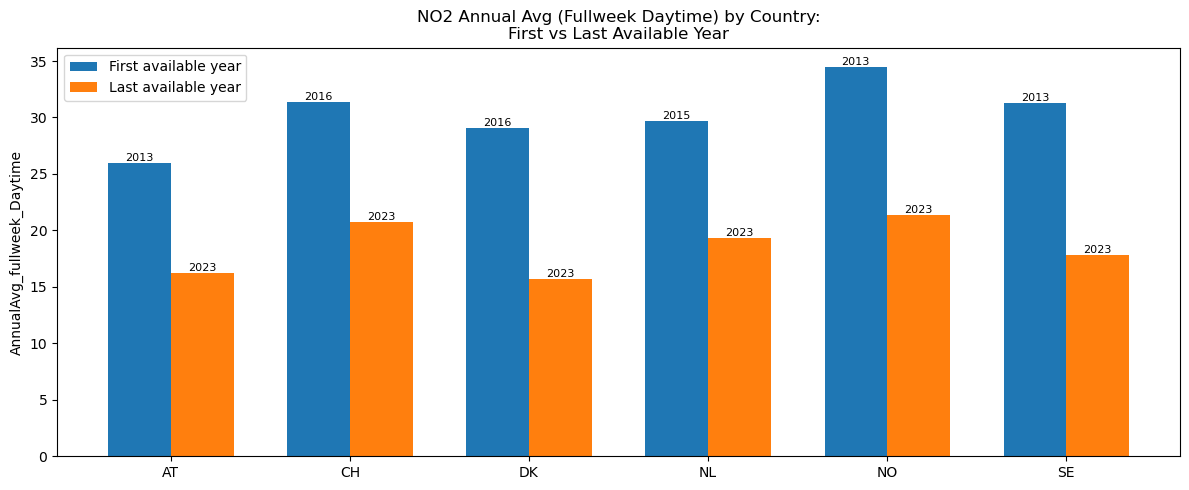

Figure already exists: ../figures/analysis_cross_section\PM2.5_first_vs_last_year_by_country.png


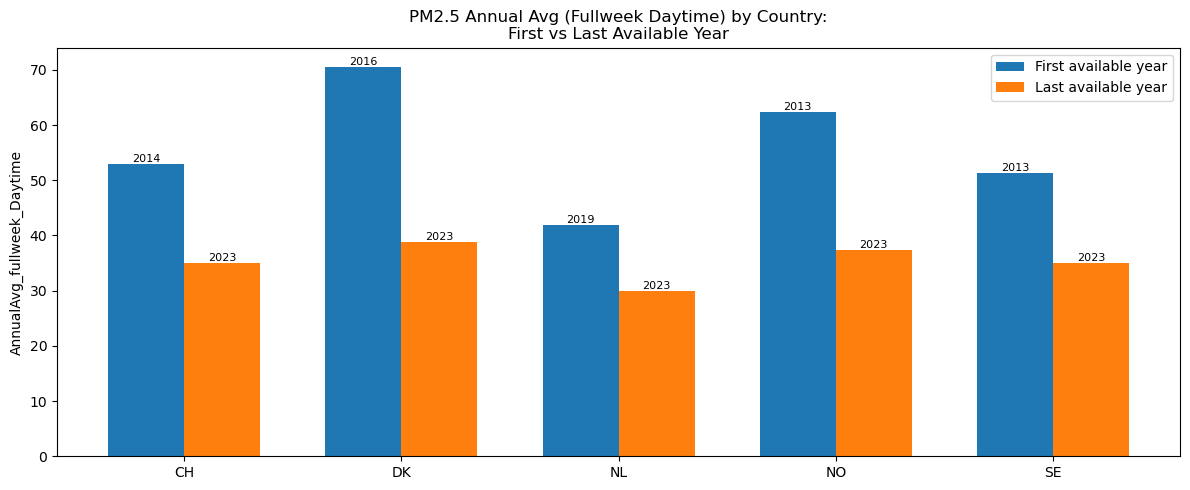

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Load data
aq = pd.read_csv("../data/processed/AQ_annual_averages.csv")

# Pollutants to plot
pollutants_to_plot = ["CO2", "NO2", "PM2.5"]

# Find first and last available year per country and pollutant
first_last = (
    aq[aq['Pollutant'].isin(pollutants_to_plot)]
    .groupby(['Country', 'Pollutant'])['Year']
    .agg(['min', 'max'])
    .reset_index()
)

# Prepare data for plotting
for pollutant in pollutants_to_plot:
    plt.figure(figsize=(12, 5))
    sub = first_last[first_last['Pollutant'] == pollutant]
    countries = sub['Country'].unique()
    x = range(len(countries))
    width = 0.35

    vals_first = []
    vals_last = []
    years_first = []
    years_last = []
    for _, row in sub.iterrows():
        y_first = aq[(aq['Country'] == row['Country']) & (aq['Pollutant'] == pollutant) & (aq['Year'] == row['min'])]['AnnualAvg_fullweek_Daytime']
        y_last = aq[(aq['Country'] == row['Country']) & (aq['Pollutant'] == pollutant) & (aq['Year'] == row['max'])]['AnnualAvg_fullweek_Daytime']
        vals_first.append(y_first.values[0] if not y_first.empty else None)
        vals_last.append(y_last.values[0] if not y_last.empty else None)
        years_first.append(row['min'])
        years_last.append(row['max'])

    plt.bar([i - width/2 for i in x], vals_first, width, label='First available year')
    plt.bar([i + width/2 for i in x], vals_last, width, label='Last available year')

    # Annotate bars with years
    for i, (y, year) in enumerate(zip(vals_first, years_first)):
        if pd.notnull(y):
            plt.text(i - width/2, y, str(year), ha='center', va='bottom', fontsize=8, rotation=0)
    for i, (y, year) in enumerate(zip(vals_last, years_last)):
        if pd.notnull(y):
            plt.text(i + width/2, y, str(year), ha='center', va='bottom', fontsize=8, rotation=0)

    plt.xticks(x, countries)
    plt.ylabel('AnnualAvg_fullweek_Daytime')
    plt.title(f'{pollutant} Annual Avg (Fullweek Daytime) by Country:\nFirst vs Last Available Year')
    plt.legend()
    plt.tight_layout()

    # Save figure if not already present
    fig_path = os.path.join(figpath, f"{pollutant}_first_vs_last_year_by_country.png")
    if not os.path.exists(fig_path):
        plt.savefig(fig_path)
        print(f"Saved: {fig_path}")
    else:
        print(f"Figure already exists: {fig_path}")
    plt.show()

# Regression models

In [15]:
# SET FIGURE PATH
# change figpath to figures/analysis´
figpath = "../figures/analysis"
os.makedirs(figpath, exist_ok=True)

In [16]:
# Load and prepare data
data = pd.read_csv("../data/processed/AQ_annual_averages.csv")
vehicle = pd.read_csv("../data/processed/combined_vehicle_data.csv")
data = data.merge(vehicle, on=['Country', 'Year'], how='left')

In [17]:
data['Pollutant'].unique()

array(['CO2', 'NO', 'NO2', 'NOX as NO2', 'PM10', 'PM2.5'], dtype=object)

In [18]:
# Add pollutant of interest for one-pollutant analysis 
pollutant = "PM2.5"

In [19]:
# Add pollutants of interest in multi-pollutant model (to run in models)
pollutants_of_interest = ["CO2", "NO2", "PM2.5", "PM10"]

In [20]:
data.head(2)

,Country,Pollutant,Year,AnnualAvg_fullweek_Daytime,AnnualAvg_fullweek_RushHour,AnnualAvg_weekday_Daytime,AnnualAvg_weekday_RushHour,AnnualAvg_weekend_Daytime,AnnualAvg_weekend_RushHour,BEV_fleet,AF_fleet,BEV_newreg,AF_newreg,BEV_mktshare,AF_mktshare
0,AT,CO2,2013,57.686461,54.268563,56.187854,52.473237,61.482014,58.790915,0.04,0.13,656,1364.0,0.21,0.44
1,AT,CO2,2014,55.550252,51.617471,54.196395,50.197445,58.963191,55.190162,0.07,0.18,1344,2347.0,0.44,0.77


### Single-country analysis

In [21]:
# OLS for all pollutants in Norway: AF_fleet as X, annual average as Y
import statsmodels.api as sm
import matplotlib.pyplot as plt

country = "NO"
pollutants = data[data["Country"] == country]["Pollutant"].unique()

for pollutant in pollutants:
    df = data[(data["Country"] == country) & (data["Pollutant"] == pollutant)].copy()
    annual_avg_cols = [col for col in df.columns if "AnnualAvg" in col]
    if not annual_avg_cols or "AF_fleet" not in df.columns:
        print(f"Skipping {pollutant}: missing columns.")
        continue
    target_col = annual_avg_cols[0]
    df = df.sort_values("AF_fleet")
    X = df["AF_fleet"].astype(float)
    y = df[target_col].astype(float)
    mask = y.notnull() & X.notnull()
    X = X[mask]
    y = y[mask]
    X_ols = sm.add_constant(X)
    model = sm.OLS(y, X_ols).fit()
    print(f"\nOLS summary for {country} - {pollutant}:")
    print(model.summary())
    plt.figure(figsize=(7,5))
    plt.scatter(X, y, label="Observed", color="blue")
    plt.plot(X, model.predict(X_ols), color="red", label="OLS fit")
    plt.xlabel("AF_fleet")
    plt.ylabel(f"{target_col} ({pollutant})")
    plt.title(f"OLS Regression: {country} {pollutant} vs AF_fleet")
    plt.legend()
    plt.tight_layout()
    plt.show()

ImportError: cannot import name 'interp1d' from 'scipy.interpolate' (unknown location)

### OLS for all countries across all pollutants


OLS summary for ALL COUNTRIES - CO2:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.028
Model:                                    OLS   Adj. R-squared:                  0.010
Method:                         Least Squares   F-statistic:                     1.593
Date:                        Sun, 18 May 2025   Prob (F-statistic):              0.212
Time:                                12:55:12   Log-Likelihood:                -201.80
No. Observations:                          58   AIC:                             407.6
Df Residuals:                              56   BIC:                             411.7
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

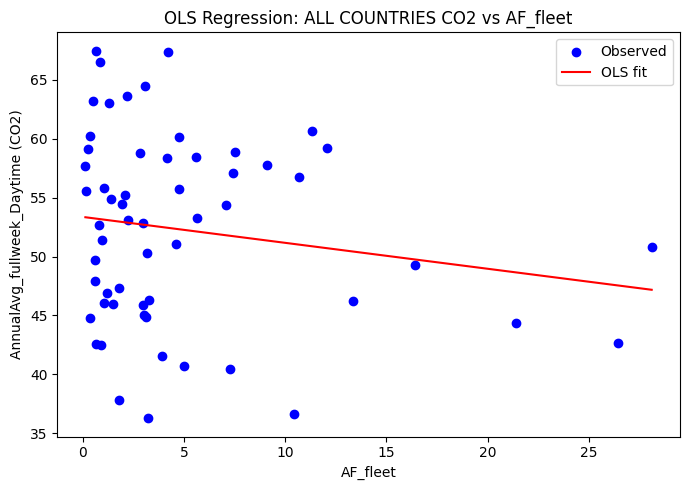


OLS summary for ALL COUNTRIES - NO:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.173
Model:                                    OLS   Adj. R-squared:                  0.156
Method:                         Least Squares   F-statistic:                     10.24
Date:                        Sun, 18 May 2025   Prob (F-statistic):            0.00241
Time:                                12:55:12   Log-Likelihood:                -125.39
No. Observations:                          51   AIC:                             254.8
Df Residuals:                              49   BIC:                             258.6
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------

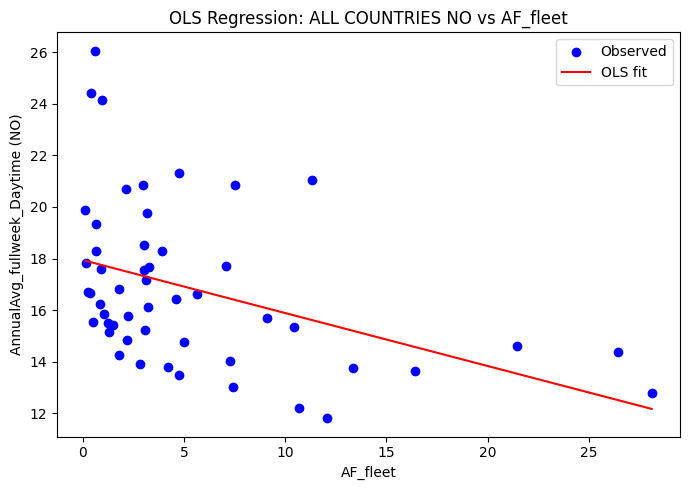


OLS summary for ALL COUNTRIES - NO2:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.076
Model:                                    OLS   Adj. R-squared:                  0.060
Method:                         Least Squares   F-statistic:                     4.548
Date:                        Sun, 18 May 2025   Prob (F-statistic):             0.0374
Time:                                12:55:12   Log-Likelihood:                -171.56
No. Observations:                          57   AIC:                             347.1
Df Residuals:                              55   BIC:                             351.2
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

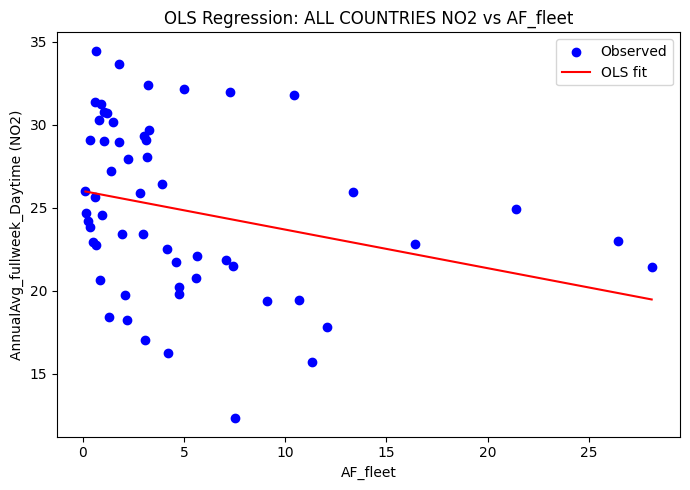


OLS summary for ALL COUNTRIES - NOX as NO2:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.180
Model:                                    OLS   Adj. R-squared:                  0.163
Method:                         Least Squares   F-statistic:                     10.57
Date:                        Sun, 18 May 2025   Prob (F-statistic):            0.00210
Time:                                12:55:13   Log-Likelihood:                -92.111
No. Observations:                          50   AIC:                             188.2
Df Residuals:                              48   BIC:                             192.0
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

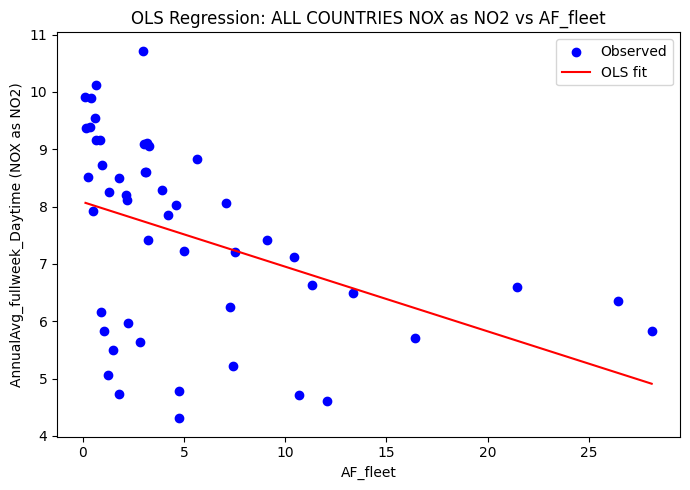


OLS summary for ALL COUNTRIES - PM10:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.054
Model:                                    OLS   Adj. R-squared:                  0.033
Method:                         Least Squares   F-statistic:                     2.616
Date:                        Sun, 18 May 2025   Prob (F-statistic):              0.113
Time:                                12:55:13   Log-Likelihood:                -136.70
No. Observations:                          48   AIC:                             277.4
Df Residuals:                              46   BIC:                             281.2
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------

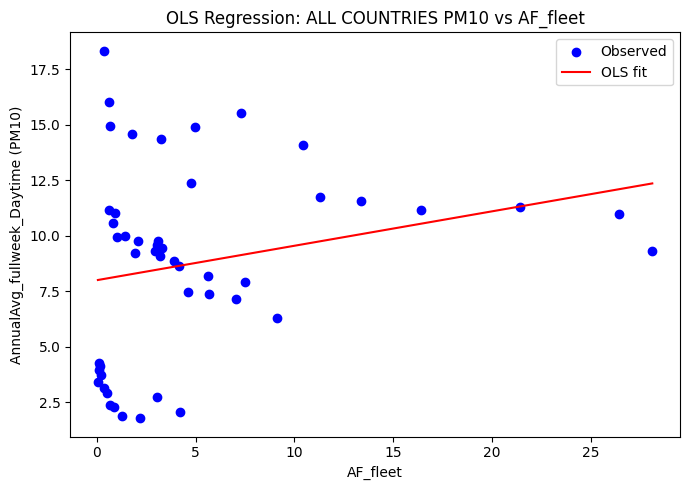


OLS summary for ALL COUNTRIES - PM2.5:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.162
Model:                                    OLS   Adj. R-squared:                  0.142
Method:                         Least Squares   F-statistic:                     8.139
Date:                        Sun, 18 May 2025   Prob (F-statistic):            0.00670
Time:                                12:55:14   Log-Likelihood:                -158.00
No. Observations:                          44   AIC:                             320.0
Df Residuals:                              42   BIC:                             323.6
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

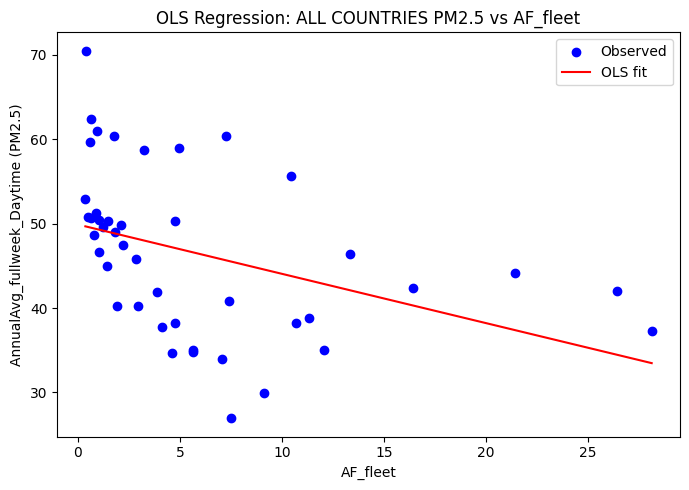

In [ ]:
# OLS for all pollutants, all countries: AF_fleet as X, annual average as Y
import statsmodels.api as sm
import matplotlib.pyplot as plt

pollutants = data["Pollutant"].unique()

for pollutant in pollutants:
    df = data[data["Pollutant"] == pollutant].copy()
    annual_avg_cols = [col for col in df.columns if "AnnualAvg" in col]
    if not annual_avg_cols or "AF_fleet" not in df.columns:
        print(f"Skipping {pollutant}: missing columns.")
        continue
    target_col = annual_avg_cols[0]
    df = df.sort_values("AF_fleet")
    X = df["AF_fleet"].astype(float)
    y = df[target_col].astype(float)
    mask = y.notnull() & X.notnull()
    X = X[mask]
    y = y[mask]
    X_ols = sm.add_constant(X)
    model = sm.OLS(y, X_ols).fit()
    print(f"\nOLS summary for ALL COUNTRIES - {pollutant}:")
    print(model.summary())
    plt.figure(figsize=(7,5))
    plt.scatter(X, y, label="Observed", color="blue")
    plt.plot(X, model.predict(X_ols), color="red", label="OLS fit")
    plt.xlabel("AF_fleet")
    plt.ylabel(f"{target_col} ({pollutant})")
    plt.title(f"OLS Regression: ALL COUNTRIES {pollutant} vs AF_fleet")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Regression variants for single pollutant, w. country Fixed Effects (AT baseline)

Saved: ../figures/analysis\PM2.5_regression_country_fixed_effects_model_colored.png


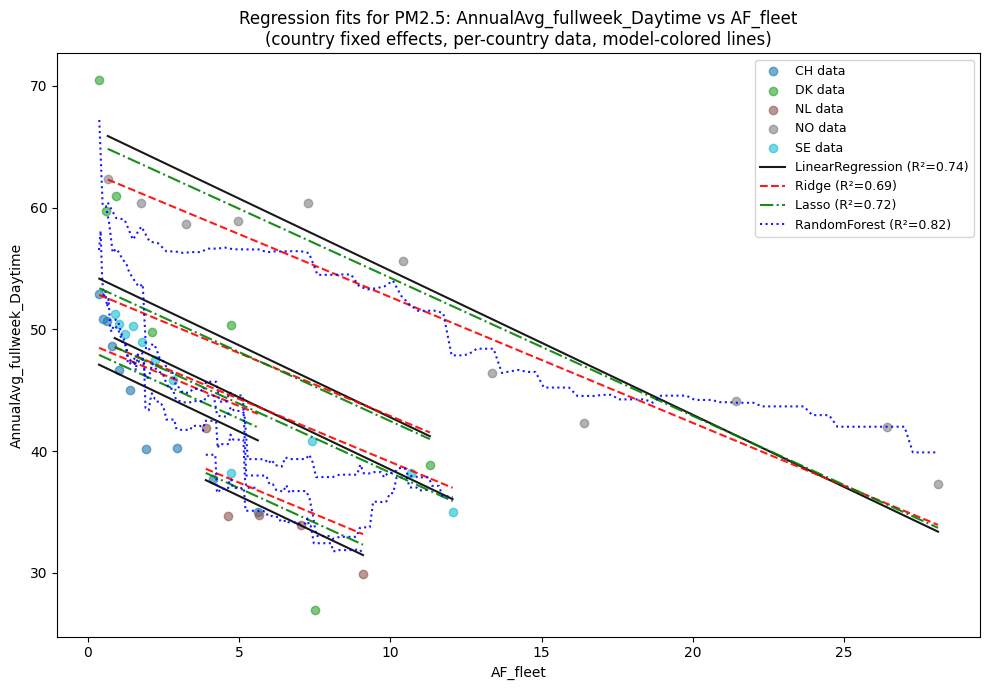

In [ ]:
# --- Visual comparison of regression variants for a single pollutant, with R^2 in legend and country fixed effects (per-country lines, model lines colored by model) ---

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Choose a pollutant and target
pollutant = pollutant
target = "AnnualAvg_fullweek_Daytime"
feature = "AF_fleet"

df = data[data['Pollutant'] == pollutant].copy()
if df.shape[0] < 6 or feature not in df.columns or target not in df.columns:
    print(f"Not enough data for {pollutant} or missing columns.")
else:
    # Save original country column for labeling
    df['_CountryOrig'] = df['Country']
    # Add country fixed effects (one-hot encoding, drop first to avoid collinearity)
    df = pd.get_dummies(df, columns=['Country'], drop_first=True)
    country_cols = [col for col in df.columns if col.startswith('Country_')]
    X_df = df[[feature] + country_cols]
    y = df[target]
    mask = (~X_df.isnull().any(axis=1)) & (~y.isnull())
    X = X_df[mask].values
    y = y[mask].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.1),
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)
    }
    model_colors = {
        "LinearRegression": "black",
        "Ridge": "red",
        "Lasso": "green",
        "RandomForest": "blue"
    }
    model_linestyles = {
        "LinearRegression": "-",
        "Ridge": "--",
        "Lasso": "-.",
        "RandomForest": ":"
    }

    # Scatter actual data, colored by country
    plt.figure(figsize=(10, 7))
    country_dummy_cols = [col for col in df.columns if col.startswith('Country_')]
    country_labels = []
    for idx, row in df[mask].iterrows():
        found = False
        for col in country_dummy_cols:
            if row[col] == 1:
                country_labels.append(col.replace('Country_', ''))
                found = True
                break
        if not found:
            country_labels.append(row['_CountryOrig'])
    unique_countries = sorted(set(country_labels))
    country_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_countries)))
    for i, country in enumerate(unique_countries):
        idxs = [j for j, c in enumerate(country_labels) if c == country]
        plt.scatter(X[idxs, 0], y[idxs], color=country_colors[i], alpha=0.6, label=f"{country} data", marker='o')

    # Plot regression lines for each country and model (model lines colored by model)
    for i, country in enumerate(unique_countries):
        idxs = [j for j, c in enumerate(country_labels) if c == country]
        x_country = X[idxs, 0]
        if len(x_country) < 3:
            continue
        x_range = np.linspace(x_country.min(), x_country.max(), 100)
        X_plot = np.zeros((100, X.shape[1]))
        X_plot[:, 0] = x_range
        # Set country dummies
        if country_dummy_cols:
            X_plot[:, 1:] = 0
            if country in [col.replace('Country_', '') for col in country_dummy_cols]:
                idx_col = [col.replace('Country_', '') for col in country_dummy_cols].index(country)
                X_plot[:, idx_col+1] = 1  # +1 because first column is feature
        for j, (name, model) in enumerate(models.items()):
            model.fit(X_train, y_train)
            y_pred_line = model.predict(X_plot)
            r2 = model.score(X_test, y_test)
            # Only label the first country for each model to avoid legend clutter
            label = f"{name} (R²={r2:.2f})" if i == 0 else None
            plt.plot(
                x_range, y_pred_line,
                color=model_colors[name],
                linestyle=model_linestyles[name],
                alpha=0.9,
                label=label
            )

    plt.xlabel(feature)
    plt.ylabel(target)
    plt.title(f"Regression fits for {pollutant}: {target} vs {feature}\n(country fixed effects, per-country data, model-colored lines)")
    handles, labels = plt.gca().get_legend_handles_labels()

    # Save figure to figures folder
    fig_path = os.path.join(figpath, f"{pollutant}_regression_country_fixed_effects_model_colored.png")
    if not os.path.exists(fig_path):
        plt.savefig(fig_path)
        print(f"Saved: {fig_path}")
    else:
        print(f"Figure already exists: {fig_path}")

    # Remove duplicate labels
    from collections import OrderedDict
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize=9)
    plt.tight_layout()
    plt.show()

### Regression fits for all pollutants_of_interest, w. country Fixed Effects where applicable (AT baseline)

In [ ]:
data['Pollutant'].unique()

array(['CO2', 'NO', 'NO2', 'NOX as NO2', 'PM10', 'PM2.5'], dtype=object)

In [ ]:
# Choose your pollutants of choice!
pollutants_of_interest = ['CO2', 'NO2', 'PM10', 'PM2.5']

In [ ]:
# --- Run regression fits for all pollutants and all AnnualAvg_* columns vs AF_fleet, with country fixed effects and model-colored lines, and print R^2 per model ---

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Ensure figures directory exists
figures_dir = "../figures/analysis"
os.makedirs(figures_dir, exist_ok=True)

# Get all pollutants and all AnnualAvg_* columns
all_pollutants = pollutants_of_interest
annualavg_cols = [col for col in data.columns if col.startswith("AnnualAvg_")]
feature = "AF_fleet"

for pollutant in all_pollutants:
    for target in annualavg_cols:
        df = data[data['Pollutant'] == pollutant].copy()
        if df.shape[0] < 6 or feature not in df.columns or target not in df.columns:
            print(f"Skipping {pollutant} - {target}: not enough data or missing columns.")
            continue
        df['_CountryOrig'] = df['Country']
        df = pd.get_dummies(df, columns=['Country'], drop_first=True)
        country_cols = [col for col in df.columns if col.startswith('Country_')]
        X_df = df[[feature] + country_cols]
        y = df[target]
        mask = (~X_df.isnull().any(axis=1)) & (~y.isnull())
        X = X_df[mask].values
        y = y[mask].values
        if len(y) < 6:
            print(f"Skipping {pollutant} - {target}: not enough valid rows after filtering.")
            continue
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        models = {
            "LinearRegression": LinearRegression(),
            "Ridge": Ridge(alpha=1.0),
            "Lasso": Lasso(alpha=0.1),
            "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)
        }
        model_colors = {
            "LinearRegression": "black",
            "Ridge": "red",
            "Lasso": "green",
            "RandomForest": "blue"
        }
        model_linestyles = {
            "LinearRegression": "-",
            "Ridge": "--",
            "Lasso": "-.",
            "RandomForest": ":"
        }

        print(f"\nPollutant: {pollutant} | Target: {target}")
        r2_dict = {}
        for name, model in models.items():
            model.fit(X_train, y_train)
            r2 = model.score(X_test, y_test)
            r2_dict[name] = r2
            print(f"  {name} R²: {r2:.3f}")

        plt.figure(figsize=(10, 7))
        country_dummy_cols = [col for col in df.columns if col.startswith('Country_')]
        country_labels = []
        for idx, row in df[mask].iterrows():
            found = False
            for col in country_dummy_cols:
                if row[col] == 1:
                    country_labels.append(col.replace('Country_', ''))
                    found = True
                    break
            if not found:
                country_labels.append(row['_CountryOrig'])
        unique_countries = sorted(set(country_labels))
        country_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_countries)))
        for i, country in enumerate(unique_countries):
            idxs = [j for j, c in enumerate(country_labels) if c == country]
            plt.scatter(X[idxs, 0], y[idxs], color=country_colors[i], alpha=0.6, label=f"{country} data", marker='o')

        for i, country in enumerate(unique_countries):
            idxs = [j for j, c in enumerate(country_labels) if c == country]
            x_country = X[idxs, 0]
            if len(x_country) < 3:
                continue
            x_range = np.linspace(x_country.min(), x_country.max(), 100)
            X_plot = np.zeros((100, X.shape[1]))
            X_plot[:, 0] = x_range
            if country_dummy_cols:
                X_plot[:, 1:] = 0
                if country in [col.replace('Country_', '') for col in country_dummy_cols]:
                    idx_col = [col.replace('Country_', '') for col in country_dummy_cols].index(country)
                    X_plot[:, idx_col+1] = 1
            for j, (name, model) in enumerate(models.items()):
                # Model already fitted above
                y_pred_line = model.predict(X_plot)
                r2 = r2_dict[name]
                label = f"{name} (R²={r2:.2f})" if i == 0 else None
                plt.plot(
                    x_range, y_pred_line,
                    color=model_colors[name],
                    linestyle=model_linestyles[name],
                    alpha=0.9,
                    label=label
                )

        plt.xlabel(feature)
        plt.ylabel(target)
        plt.title(f"Regression fits for {pollutant}: {target} vs {feature}\n(country fixed effects, per-country data, model-colored lines)")
        handles, labels = plt.gca().get_legend_handles_labels()
        from collections import OrderedDict
        by_label = OrderedDict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize=9)
        plt.tight_layout()
        fig_path = os.path.join(figures_dir, f"{pollutant}_{target}_regression_country_fixed_effects_model_colored.png")
        plt.savefig(fig_path)
        print(f"Saved: {fig_path}")
        plt.close()


Pollutant: CO2 | Target: AnnualAvg_fullweek_Daytime
  LinearRegression R²: 0.817
  Ridge R²: 0.714
  Lasso R²: 0.803
  RandomForest R²: 0.777
Saved: ../figures/analysis\CO2_AnnualAvg_fullweek_Daytime_regression_country_fixed_effects_model_colored.png

Pollutant: CO2 | Target: AnnualAvg_fullweek_RushHour
  LinearRegression R²: 0.787
  Ridge R²: 0.699
  Lasso R²: 0.777
  RandomForest R²: 0.679
Saved: ../figures/analysis\CO2_AnnualAvg_fullweek_RushHour_regression_country_fixed_effects_model_colored.png

Pollutant: CO2 | Target: AnnualAvg_weekday_Daytime
  LinearRegression R²: 0.788
  Ridge R²: 0.690
  Lasso R²: 0.778
  RandomForest R²: 0.728
Saved: ../figures/analysis\CO2_AnnualAvg_weekday_Daytime_regression_country_fixed_effects_model_colored.png

Pollutant: CO2 | Target: AnnualAvg_weekday_RushHour
  LinearRegression R²: 0.757
  Ridge R²: 0.670
  Lasso R²: 0.749
  RandomForest R²: 0.657
Saved: ../figures/analysis\CO2_AnnualAvg_weekday_RushHour_regression_country_fixed_effects_model_colo

In [ ]:
# --- Table of best and worst performing model/pollutant/AnnualAvg_ combinations across pollutants_of_interest ---
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def significance_stars(p):
    if pd.isnull(p):
        return ""
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

results = []

for pollutant in pollutants_of_interest:
    for target in [col for col in data.columns if col.startswith("AnnualAvg_")]:
        df = data[data['Pollutant'] == pollutant].copy()
        if df.shape[0] < 6 or "AF_fleet" not in df.columns or target not in df.columns:
            continue
        df['_CountryOrig'] = df['Country']
        df = pd.get_dummies(df, columns=['Country'], drop_first=True)
        country_cols = [col for col in df.columns if col.startswith('Country_')]
        X_df = df[["AF_fleet"] + country_cols]
        y = df[target]
        mask = (~X_df.isnull().any(axis=1)) & (~y.isnull())
        X = X_df[mask].values
        y = y[mask].values
        if len(y) < 6:
            continue
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # LinearRegression with p-value (using statsmodels)
        X_train_sm = sm.add_constant(X_train)
        X_train_sm = np.asarray(X_train_sm, dtype=np.float64)
        y_train = np.asarray(y_train, dtype=np.float64)
        ols_model = sm.OLS(y_train, X_train_sm).fit()
        r2 = ols_model.rsquared
        p_value = ols_model.pvalues[1] if len(ols_model.pvalues) > 1 else None
        stars = significance_stars(p_value)

        results.append({
            "Pollutant": pollutant,
            "Target": target,
            "Model": "LinearRegression",
            "R2_test": r2,
            "R2_train": None,
            "Overfit_gap": None,
            "p_value": p_value,
            "stars": stars
        })

        # Ridge, Lasso, RandomForest (with train/test R2 and overfit gap)
        for name, model in [("Ridge", Ridge(alpha=1.0)), ("Lasso", Lasso(alpha=0.1)), ("RandomForest", RandomForestRegressor(n_estimators=100, random_state=42))]:
            model.fit(X_train, y_train)
            r2_train = model.score(X_train, y_train)
            r2_test = model.score(X_test, y_test)
            overfit_gap = r2_train - r2_test
            results.append({
                "Pollutant": pollutant,
                "Target": target,
                "Model": name,
                "R2_test": r2_test,
                "R2_train": r2_train,
                "Overfit_gap": overfit_gap,
                "p_value": None,
                "stars": ""
            })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Find the best model for each pollutant/target combination
best_results = results_df.loc[results_df.groupby(['Pollutant', 'Target'])['R2_test'].idxmax()].reset_index(drop=True)
best_results = best_results.sort_values(by="R2_test", ascending=False)
best_results.to_csv("../results/best_model_per_pollutant_target.csv", index=False)

# Find the worst model for each pollutant/target combination
worst_results = results_df.loc[results_df.groupby(['Pollutant', 'Target'])['R2_test'].idxmin()].reset_index(drop=True)
worst_results = worst_results.sort_values(by="R2_test", ascending=True)
worst_results.to_csv("../results/worst_model_per_pollutant_target.csv", index=False)

print("Best performing model for each pollutant and AnnualAvg_ column:")
print(best_results.head(10))
print("Worst performing model for each pollutant and AnnualAvg_ column:")
print(worst_results.head(10))

Best performing model for each pollutant and AnnualAvg_ column:
   Pollutant                      Target             Model   R2_test  \
11       NO2  AnnualAvg_weekend_RushHour      RandomForest  0.881065   
10       NO2   AnnualAvg_weekend_Daytime      RandomForest  0.849895   
4        CO2   AnnualAvg_weekend_Daytime             Lasso  0.840920   
5        CO2  AnnualAvg_weekend_RushHour             Lasso  0.827284   
22     PM2.5   AnnualAvg_weekend_Daytime      RandomForest  0.825781   
18     PM2.5  AnnualAvg_fullweek_Daytime      RandomForest  0.821781   
14      PM10   AnnualAvg_weekday_Daytime  LinearRegression  0.812437   
15      PM10  AnnualAvg_weekday_RushHour  LinearRegression  0.805536   
0        CO2  AnnualAvg_fullweek_Daytime             Lasso  0.803122   
12      PM10  AnnualAvg_fullweek_Daytime  LinearRegression  0.799651   

    R2_train  Overfit_gap   p_value stars  
11  0.952906     0.071841       NaN        
10  0.951189     0.101295       NaN        
4   0.70760

In [ ]:
# --- Table of best and worst performing model/pollutant/AnnualAvg_ combinations across pollutants_of_interest ---
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

def significance_stars(p):
    if pd.isnull(p):
        return ""
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

results = []

for pollutant in pollutants_of_interest:
    for target in [col for col in data.columns if col.startswith("AnnualAvg_")]:
        df = data[data['Pollutant'] == pollutant].copy()
        if df.shape[0] < 6 or "AF_fleet" not in df.columns or target not in df.columns:
            continue
        df['_CountryOrig'] = df['Country']
        df = pd.get_dummies(df, columns=['Country'], drop_first=True)
        country_cols = [col for col in df.columns if col.startswith('Country_')]
        X_df = df[["AF_fleet"] + country_cols]
        y = df[target]
        mask = (~X_df.isnull().any(axis=1)) & (~y.isnull())
        X = X_df[mask].values
        y = y[mask].values
        if len(y) < 6:
            continue
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # LinearRegression with p-value (using statsmodels)
        X_train_sm = sm.add_constant(X_train)
        X_train_sm = np.asarray(X_train_sm, dtype=np.float64)
        y_train = np.asarray(y_train, dtype=np.float64)
        ols_model = sm.OLS(y_train, X_train_sm).fit()
        r2 = ols_model.rsquared
        p_value = ols_model.pvalues[1] if len(ols_model.pvalues) > 1 else None
        stars = significance_stars(p_value)

        results.append({
            "Pollutant": pollutant,
            "Target": target,
            "Model": "LinearRegression",
            "R2_test": r2,
            "R2_train": None,
            "Overfit_gap": None,
            "p_value": p_value,
            "stars": stars,
            "Best_params": None
        })

        # Ridge with reduced hyperparameter tuning
        ridge_params = {
            "alpha": np.logspace(-3, 2, 5),  # 1e-3 to 1e2, 5 values
            "fit_intercept": [True, False]
        }
        ridge = Ridge(max_iter=10000)
        ridge_cv = GridSearchCV(ridge, ridge_params, cv=3, scoring='r2', n_jobs=-1)
        ridge_cv.fit(X_train, y_train)
        best_ridge = ridge_cv.best_estimator_
        r2_train = best_ridge.score(X_train, y_train)
        r2_test = best_ridge.score(X_test, y_test)
        overfit_gap = r2_train - r2_test
        results.append({
            "Pollutant": pollutant,
            "Target": target,
            "Model": "Ridge",
            "R2_test": r2_test,
            "R2_train": r2_train,
            "Overfit_gap": overfit_gap,
            "p_value": None,
            "stars": "",
            "Best_params": ridge_cv.best_params_
        })

        # Lasso with reduced hyperparameter tuning
        lasso_params = {
            "alpha": np.logspace(-3, 1, 5),  # 1e-3 to 10, 5 values
            "fit_intercept": [True, False]
        }
        lasso = Lasso(max_iter=10000)
        lasso_cv = GridSearchCV(lasso, lasso_params, cv=3, scoring='r2', n_jobs=-1)
        lasso_cv.fit(X_train, y_train)
        best_lasso = lasso_cv.best_estimator_
        r2_train = best_lasso.score(X_train, y_train)
        r2_test = best_lasso.score(X_test, y_test)
        overfit_gap = r2_train - r2_test
        results.append({
            "Pollutant": pollutant,
            "Target": target,
            "Model": "Lasso",
            "R2_test": r2_test,
            "R2_train": r2_train,
            "Overfit_gap": overfit_gap,
            "p_value": None,
            "stars": "",
            "Best_params": lasso_cv.best_params_
        })

        # RandomForest with reduced hyperparameter tuning
        rf_params = {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "max_features": ["sqrt", "log2"]
        }
        rf = RandomForestRegressor(random_state=42)
        rf_cv = GridSearchCV(rf, rf_params, cv=3, scoring='r2', n_jobs=-1)
        rf_cv.fit(X_train, y_train)
        best_rf = rf_cv.best_estimator_
        r2_train = best_rf.score(X_train, y_train)
        r2_test = best_rf.score(X_test, y_test)
        overfit_gap = r2_train - r2_test
        results.append({
            "Pollutant": pollutant,
            "Target": target,
            "Model": "RandomForest",
            "R2_test": r2_test,
            "R2_train": r2_train,
            "Overfit_gap": overfit_gap,
            "p_value": None,
            "stars": "",
            "Best_params": rf_cv.best_params_
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Find the best model for each pollutant/target combination
best_results = results_df.loc[results_df.groupby(['Pollutant', 'Target'])['R2_test'].idxmax()].reset_index(drop=True)
best_results = best_results.sort_values(by="R2_test", ascending=False)
best_results.to_csv("../results/best_model_per_pollutant_target.csv", index=False)

# Find the worst model for each pollutant/target combination
worst_results = results_df.loc[results_df.groupby(['Pollutant', 'Target'])['R2_test'].idxmin()].reset_index(drop=True)
worst_results = worst_results.sort_values(by="R2_test", ascending=True)
worst_results.to_csv("../results/worst_model_per_pollutant_target.csv", index=False)

print("Best performing model for each pollutant and AnnualAvg_ column:")
print(best_results.head(10))
print("Worst performing model for each pollutant and AnnualAvg_ column:")
print(worst_results.head(10))

Best performing model for each pollutant and AnnualAvg_ column:
   Pollutant                       Target         Model   R2_test  R2_train  \
10       NO2    AnnualAvg_weekend_Daytime  RandomForest  0.878415  0.963526   
11       NO2   AnnualAvg_weekend_RushHour  RandomForest  0.870109  0.959786   
20     PM2.5    AnnualAvg_weekday_Daytime  RandomForest  0.868231  0.948569   
4        CO2    AnnualAvg_weekend_Daytime         Lasso  0.865349  0.744759   
18     PM2.5   AnnualAvg_fullweek_Daytime  RandomForest  0.857062  0.949512   
23     PM2.5   AnnualAvg_weekend_RushHour  RandomForest  0.854076  0.963972   
19     PM2.5  AnnualAvg_fullweek_RushHour  RandomForest  0.849990  0.949687   
5        CO2   AnnualAvg_weekend_RushHour         Lasso  0.846920  0.713906   
21     PM2.5   AnnualAvg_weekday_RushHour  RandomForest  0.845942  0.946368   
7        NO2  AnnualAvg_fullweek_RushHour  RandomForest  0.840733  0.952241   

    Overfit_gap  p_value stars  \
10     0.085111      NaN        

## Takes ages to run - try on Clara's?

In [ ]:
# --- Table of best and worst performing model/pollutant/AnnualAvg_ combinations across pollutants_of_interest ---
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

def significance_stars(p):
    if pd.isnull(p):
        return ""
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

results = []

for pollutant in pollutants_of_interest:
    for target in [col for col in data.columns if col.startswith("AnnualAvg_")]:
        df = data[data['Pollutant'] == pollutant].copy()
        if df.shape[0] < 6 or "AF_fleet" not in df.columns or target not in df.columns:
            continue
        df['_CountryOrig'] = df['Country']
        df = pd.get_dummies(df, columns=['Country'], drop_first=True)
        country_cols = [col for col in df.columns if col.startswith('Country_')]
        X_df = df[["AF_fleet"] + country_cols]
        y = df[target]
        mask = (~X_df.isnull().any(axis=1)) & (~y.isnull())
        X = X_df[mask].values
        y = y[mask].values
        if len(y) < 6:
            continue
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # LinearRegression with p-value (using statsmodels)
        X_train_sm = sm.add_constant(X_train)
        X_train_sm = np.asarray(X_train_sm, dtype=np.float64)
        y_train = np.asarray(y_train, dtype=np.float64)
        ols_model = sm.OLS(y_train, X_train_sm).fit()
        r2 = ols_model.rsquared
        p_value = ols_model.pvalues[1] if len(ols_model.pvalues) > 1 else None
        stars = significance_stars(p_value)

        results.append({
            "Pollutant": pollutant,
            "Target": target,
            "Model": "LinearRegression",
            "R2_test": r2,
            "R2_train": None,
            "Overfit_gap": None,
            "p_value": p_value,
            "stars": stars,
            "Best_params": None
        })

        # Ridge with hyperparameter tuning
        ridge_params = {
            "alpha": np.logspace(-4, 3, 15),  # 1e-4 to 1e3, 15 values
            "fit_intercept": [True, False],
            "solver": ["auto", "svd", "cholesky", "lsqr", "sag", "saga"]
        }
        ridge = Ridge(max_iter=10000)
        ridge_cv = GridSearchCV(ridge, ridge_params, cv=3, scoring='r2')
        ridge_cv.fit(X_train, y_train)
        best_ridge = ridge_cv.best_estimator_
        r2_train = best_ridge.score(X_train, y_train)
        r2_test = best_ridge.score(X_test, y_test)
        overfit_gap = r2_train - r2_test
        results.append({
            "Pollutant": pollutant,
            "Target": target,
            "Model": "Ridge",
            "R2_test": r2_test,
            "R2_train": r2_train,
            "Overfit_gap": overfit_gap,
            "p_value": None,
            "stars": "",
            "Best_params": ridge_cv.best_params_
        })

        # Lasso with hyperparameter tuning
        lasso_params = {
            "alpha": np.logspace(-4, 2, 15),  # 1e-4 to 1e2, 15 values
            "fit_intercept": [True, False],
            "selection": ["cyclic", "random"]
        }
        lasso = Lasso(max_iter=10000)
        lasso_cv = GridSearchCV(lasso, lasso_params, cv=3, scoring='r2')
        lasso_cv.fit(X_train, y_train)
        best_lasso = lasso_cv.best_estimator_
        r2_train = best_lasso.score(X_train, y_train)
        r2_test = best_lasso.score(X_test, y_test)
        overfit_gap = r2_train - r2_test
        results.append({
            "Pollutant": pollutant,
            "Target": target,
            "Model": "Lasso",
            "R2_test": r2_test,
            "R2_train": r2_train,
            "Overfit_gap": overfit_gap,
            "p_value": None,
            "stars": "",
            "Best_params": lasso_cv.best_params_
        })

        # RandomForest with hyperparameter tuning
        rf_params = {
            "n_estimators": [50, 100, 200, 300, 500],
            "max_depth": [None, 3, 5, 7, 10, 15],
            "min_samples_split": [2, 3, 5, 8],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["auto", "sqrt", "log2"]
        }
        rf = RandomForestRegressor(random_state=42)
        rf_cv = GridSearchCV(rf, rf_params, cv=3, scoring='r2', n_jobs=-1)
        rf_cv.fit(X_train, y_train)
        best_rf = rf_cv.best_estimator_
        r2_train = best_rf.score(X_train, y_train)
        r2_test = best_rf.score(X_test, y_test)
        overfit_gap = r2_train - r2_test
        results.append({
            "Pollutant": pollutant,
            "Target": target,
            "Model": "RandomForest",
            "R2_test": r2_test,
            "R2_train": r2_train,
            "Overfit_gap": overfit_gap,
            "p_value": None,
            "stars": "",
            "Best_params": rf_cv.best_params_
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Find the best model for each pollutant/target combination
best_results = results_df.loc[results_df.groupby(['Pollutant', 'Target'])['R2_test'].idxmax()].reset_index(drop=True)
best_results = best_results.sort_values(by="R2_test", ascending=False)
best_results.to_csv("../results/best_model_per_pollutant_target.csv", index=False)

# Find the worst model for each pollutant/target combination
worst_results = results_df.loc[results_df.groupby(['Pollutant', 'Target'])['R2_test'].idxmin()].reset_index(drop=True)
worst_results = worst_results.sort_values(by="R2_test", ascending=True)
worst_results.to_csv("../results/worst_model_per_pollutant_target.csv", index=False)

print("Best performing model for each pollutant and AnnualAvg_ column:")
print(best_results.head(10))
print("Worst performing model for each pollutant and AnnualAvg_ column:")
print(worst_results.head(10))

c:\Users\jskif\Anaconda3\envs\dsml_EV_project\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
410 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jskif\Anaconda3\envs\dsml_EV_project\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jskif\Anaconda3\envs\dsml_EV_project\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\jskif\Anaconda3\envs\dsml_EV_project\Lib\site-packages\sklearn\base.py", line 436, in _validate_param

KeyboardInterrupt: 

## Lazypredict testing (negligible results)

In [ ]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from contextlib import redirect_stdout, redirect_stderr
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression


# Set LightGBM and Python warnings to be quiet
os.environ["PYTHONWARNINGS"] = "ignore"
os.environ["LIGHTGBM_VERBOSE"] = "0"

class suppress_all_output:
    def __enter__(self):
        import os
        self.devnull = open(os.devnull, 'w')
        self.old_stdout = sys.stdout
        self.old_stderr = sys.stderr
        sys.stdout = self.devnull
        sys.stderr = self.devnull
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr
        self.devnull.close()

# Load and prepare data
data = pd.read_csv("../data/processed/AQ_annual_averages.csv")
vehicle = pd.read_csv("../data/processed/combined_vehicle_data.csv")
data = data.merge(vehicle, on=['Country', 'Year'], how='left')

feature_cols = ['AF_fleet']
target_cols = [col for col in data.columns if "AnnualAvg_fullweek_Daytime" in col]

output_dir = "../results"
fig_dir = "../figures"
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

results_list = []

warnings.filterwarnings("ignore")  # Hide warnings from sklearn and statsmodels

pollutants_to_run = ["CO2", "NO2", "PM2.5", "PM10"]

for pollutant in pollutants_to_run:
    df = data[data['Pollutant'] == pollutant].copy()
    if df.shape[0] < 6:
        print(f"Skipping {pollutant}: not enough rows ({df.shape[0]})")
        continue
    df = pd.get_dummies(df, columns=['Country'], drop_first=True)
    for target in target_cols:
        for feature in feature_cols:
            if feature not in df.columns or target not in df.columns:
                continue
            X = df[[feature] + [col for col in df.columns if col.startswith('Country_')]]
            y = df[target]
            mask = y.notnull() & X[feature].notnull()
            print(f"{pollutant} - {target} vs {feature}: {mask.sum()} valid rows")
            if mask.sum() < 6:
                continue
            try:
                X_train, X_test, y_train, y_test = train_test_split(X[mask], y[mask], test_size=0.2, random_state=42)
                with suppress_all_output(), redirect_stdout(sys.stderr), redirect_stderr(sys.stderr):
                    reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
                    # Remove unwanted models from results
                    exclude_models = ['GaussianProcessRegressor', 'MLPRegressor', 'KernelRidge']
                    models = models.drop(index=[m for m in models.index if m in exclude_models], errors='ignore')
                    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
                print("models shape:", models.shape)
                print("models columns:", models.columns)
                print(models.head())
                r2_col = [col for col in models.columns if 'r2' in col.lower() or 'r-squared' in col.lower() or 'squared' in col.lower()]
                if not r2_col:
                    print("No R2 column found in models!")
                    continue
                if models.empty:
                    print("Models DataFrame is empty!")
                    continue
                best_idx = models[r2_col[0]].idxmax()
                best_model_name = best_idx  # since the index is the model name
                best_model = reg.models[best_model_name]
                y_pred = best_model.predict(X_test)

                # After y_pred = best_model.predict(X_test)
                outlier_mask = np.abs(y_pred - y_test) > (3 * np.std(y_pred))  # or pick a threshold
                print("Outlier indices in test set:", X_test.index[outlier_mask])
                print("Actual values:", y_test[outlier_mask])
                print("Predicted values:", y_pred[outlier_mask])
                print("Full test row(s):")
                print(X_test.loc[X_test.index[outlier_mask]])

                y_pred_all = best_model.predict(X[mask])
                plt.figure(figsize=(7, 7))
                # Predict for all data
                y_pred_all = best_model.predict(X[mask])

                # Plot train points
                train_mask = X[mask].index.isin(X_train.index)
                plt.scatter(y[mask][train_mask], y_pred_all[train_mask], alpha=0.7, label="Train", color="tab:blue", marker="o")
                # Plot test points
                test_mask = X[mask].index.isin(X_test.index)
                plt.scatter(y[mask][test_mask], y_pred_all[test_mask], alpha=0.7, label="Test", color="tab:orange", marker="s")

                # Regression line (fit only on test set for fair eval)
                z = np.polyfit(y_test, y_pred, 1)
                p = np.poly1d(z)
                plt.plot(y_test, p(y_test), "b--", label="Regression line")

                plt.xlabel("Actual")
                plt.ylabel("Predicted")
                plt.title(f"Best: {best_model_name}\n{pollutant} - {target} vs {feature} (fixed effects)\nR2={models.loc[best_idx][r2_col[0]]:.2f}")
                plt.legend()
                plt.tight_layout()
                fig_path = os.path.join(fig_dir, f"bestmodel_allcountries_{pollutant}_{target}_fe.png")
                if not os.path.exists(fig_path):
                    plt.savefig(fig_path)
                    print(f"Saved: {fig_path}")
                plt.show()
                plt.close()
                models['Pollutant'] = pollutant
                models['Target'] = target
                models['Feature'] = feature
                results_list.append(models.loc[[best_idx]])
            except Exception as e:
                print(f"Error for {pollutant} - {target} vs {feature}: {repr(e)}")
if results_list:
    all_results = pd.concat(results_list, ignore_index=True)
    all_results.to_csv(os.path.join(output_dir, "best_model_results_summary_allcountries.csv"), index=False)
    print("Saved all best model results to best_model_results_summary_allcountries.csv")
else:
    print("No valid model runs: check your data and thresholds!")

CO2 - AnnualAvg_fullweek_Daytime vs AF_fleet: 58 valid rows
Error for CO2 - AnnualAvg_fullweek_Daytime vs AF_fleet: AttributeError("'dict' object has no attribute 'drop'")
NO2 - AnnualAvg_fullweek_Daytime vs AF_fleet: 57 valid rows
Error for NO2 - AnnualAvg_fullweek_Daytime vs AF_fleet: AttributeError("'dict' object has no attribute 'drop'")
PM2.5 - AnnualAvg_fullweek_Daytime vs AF_fleet: 44 valid rows
Error for PM2.5 - AnnualAvg_fullweek_Daytime vs AF_fleet: AttributeError("'dict' object has no attribute 'drop'")
PM10 - AnnualAvg_fullweek_Daytime vs AF_fleet: 48 valid rows
Error for PM10 - AnnualAvg_fullweek_Daytime vs AF_fleet: AttributeError("'dict' object has no attribute 'drop'")
No valid model runs: check your data and thresholds!
